### <Center> Predicting Wine Quality with k-Nearest Neighbours<Center>
In this project, k-NN is used to predict the wine quality of individual wines based on features which include fixed acidity, chlorides, density, pH, etc. A dataset "sparklingwine.csv" comprising of these features is used.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support as score

### (1) Load data file

In [20]:
df_wine = pd.read_csv("./sparklingwine.csv", sep=';')
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,5
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### (2) Construct new binary column "good wine"
#### "good wine" has value of 1 when quality >= 6 and value of 0 when quality < 0

In [21]:
df_wine['good wine'] = df_wine['quality'].apply(lambda x:1 if x>=6 else 0)

### (3) Split data into training, validation & test sets

In [22]:
#Features: everything except quality & good wine
X = df_wine.drop(['quality','good wine'], axis=1)

#Label: good wine
y = df_wine['good wine']

#Split data into combined (training + validation) and testing set, then split combined set into training set and validation set
#Combined set to be used for retraining of model
X_comb, X_test, y_comb, y_test = train_test_split(X, y, test_size = 0.25, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_comb, y_comb, test_size = 1/3, shuffle = False)

### (4) Normalise data according to Z-score transform

In [23]:
#Scale all data sets using mean and standard deviation of features in training set
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_n = scaler.transform(X_train) 
X_test_n = scaler.transform(X_test)
X_val_n = scaler.transform(X_val)

#Scale combined data for retraining
scaler_new = preprocessing.StandardScaler().fit(X_comb)
X_comb_n = scaler_new.transform(X_comb)

### (5) Load and Train k-NN classifiers

#### (a) Predict values using different classifiers and calculate various performance metrics for each classifier
We decided on the performance measures of Accuracy, Precision, Recall and F1 score to select the best value of k.


Precision is an important metric for the wine business as we do not want to misclassify bad wine as good wine, which could impact reputation of the business and service quality.
Recall is also an important metric as a high rate of false negatives could mean that the wine business could be understating the quality of their wines and missing out on identifying good wines.

In [24]:
accuracy_scores = {}
result_dic ={'k':[],'Accuracy':[], 'Precision':[], 'Recall':[],'F1':[]}

distance_metric = 'euclidean'

#Loop for values of k from 1 to 100 to generate different models and obtain performance metrics for each model
for k in range(1,101):
    clf = KNeighborsClassifier(n_neighbors = k, algorithm = 'auto', metric = distance_metric)
    clf.fit(X_train_n, y_train)
    y_pred = clf.predict(X_val_n)
    
    accuracy_scores[k] = metrics.accuracy_score(y_val, y_pred)
    
    result_dic['k'].append(k)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    precision, recall, F1, support = score(y_val, y_pred, average='macro')
    result_dic['Accuracy'].append(accuracy)
    result_dic['Precision'].append(precision)
    result_dic['Recall'].append(recall)
    result_dic['F1'].append(F1)

#### (b) Identify Top 5 'k's which gives highest accuracy, precision, recall and F1 score on validation data sets
k = 15 ranks in 1st place for Accuracy, Precision and F1 and 2nd for Recall.

In [25]:
optimal_k = pd.DataFrame (result_dic, columns=['k','Accuracy', 'Precision', 'Recall', 'F1'])

#Top 5 in Accuracy Score
top_accuracy = optimal_k.nlargest(5,'Accuracy')
top_accuracy.style.hide_index()

k,Accuracy,Precision,Recall,F1
15,0.89,0.921329,0.832261,0.860477
16,0.88,0.91531,0.816636,0.845976
18,0.88,0.91531,0.816636,0.845976
7,0.875,0.903496,0.81296,0.840515
9,0.875,0.912333,0.808824,0.838579


In [26]:
#Top 5 in Precision Score
top_precision = optimal_k.nlargest(5,'Precision')
top_precision.style.hide_index()

k,Accuracy,Precision,Recall,F1
15,0.89,0.921329,0.832261,0.860477
8,0.87,0.919753,0.796875,0.828925
16,0.88,0.91531,0.816636,0.845976
18,0.88,0.91531,0.816636,0.845976
9,0.875,0.912333,0.808824,0.838579


In [27]:
#Top 5 in Recall Score
top_recall = optimal_k.nlargest(5,'Recall')
top_recall.style.hide_index()

k,Accuracy,Precision,Recall,F1
1,0.86,0.836264,0.851562,0.842891
15,0.89,0.921329,0.832261,0.860477
5,0.865,0.85284,0.830423,0.840043
17,0.875,0.895699,0.817096,0.842366
19,0.875,0.895699,0.817096,0.842366


In [28]:
#Top 5 in F1 Score
top_f1 = optimal_k.nlargest(5,'F1')
top_f1.style.hide_index()

k,Accuracy,Precision,Recall,F1
15,0.89,0.921329,0.832261,0.860477
16,0.88,0.91531,0.816636,0.845976
18,0.88,0.91531,0.816636,0.845976
1,0.86,0.836264,0.851562,0.842891
17,0.875,0.895699,0.817096,0.842366


#### (c) Plot validation data set accuracy against value of k
k = 15 gives the highest accuracy of 0.89 on the validation set.

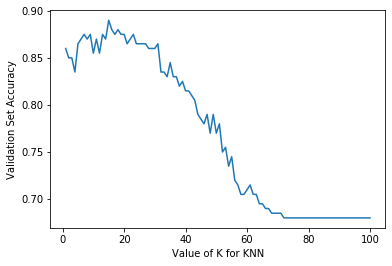

In [29]:
x_acc = list(accuracy_scores.keys())
y_acc = list(accuracy_scores.values())

plt.plot(x_acc,y_acc)
plt.xlabel('Value of K for KNN')
plt.ylabel('Validation Set Accuracy')
plt.show()

### (7) Predict generalisation error using test data set

#### (a) Use combined data set (training + validation sets) to retrain model

In [30]:
#Retrain model on combined data set using k = 15
clf_new = KNeighborsClassifier(n_neighbors = 15, algorithm = 'auto', metric = distance_metric)
clf_new.fit(X_comb_n, y_comb)
y_pred_comb = clf_new.predict(X_test_n)

#### (b) Compute Generalisation error and Accuracy score of test set using retrained model

In [31]:
model_error = np.mean(y_pred_comb != y_test)
print("Generalisation error: " + str(model_error))
model_accuracy_score = metrics.accuracy_score(y_test, y_pred_comb)
print("Accuracy score: " + str(model_accuracy_score))

Generalisation error: 0.025
Accuracy score: 0.975


### How to judge whether classifier is well-suited for data set?

The accuracy score of using the retrained model on the test data set is 97.5% which is high. We also used cross-validation, below, to judge if classifier is well-suited for the data set. From the accuracy of 0.88 obtained, we believe the classifier is well-suited.

In [32]:
scores = cross_val_score(clf_new, X, y, cv = 3)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.88 (+/- 0.02)
